# Data Science Template 

## Import Data

In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [118]:
path = 'Mckinsey_Insurance/'
file_train = 'train_ZoGVYWq.csv'
file_test = 'test_66516Ee.csv'
df_train_pre = pd.read_csv(path+file_train)
df_test_pre = pd.read_csv(path+file_test)

## Preprocessing

In [119]:
from sklearn.preprocessing import Imputer
from sklearn_pandas import DataFrameMapper, gen_features, CategoricalImputer

In [120]:
#selecting columns of different types
target = 'renewal'
y = df_train_pre[target]
col_object = df_train_pre.select_dtypes('O').columns
col_num = df_train_pre.drop([target,'id'],axis=1).select_dtypes(['int64','float64']).columns
col_dates = df_train_pre.drop('id',axis=1).select_dtypes(['datetime64','timedelta64']).columns

In [121]:
def fill_na(df,col_object,col_num,col_dates):
    imp_obj = gen_features(
            columns=[[x] for x in col_object],
            classes=[CategoricalImputer]
        )

    imp_num = gen_features(            
        columns=[[x] for x in col_num],
        classes=[{'class': Imputer, 'strategy': 'median'}]
    )
    
    na_mapper = DataFrameMapper(imp_num+imp_obj,df_out=True)
    
    return na_mapper.fit_transform(df)

In [122]:
df_train = fill_na(df_train_pre,col_object,col_num,col_dates)
df_test = fill_na(df_test_pre,col_object,col_num,col_dates)

## Feature Engineering 

In [123]:
from sklearn_pandas import DataFrameMapper, gen_features, CategoricalImputer
from category_encoders import TargetEncoder

In [124]:
target_cat = gen_features(
    columns=[[x] for x in col_object],
    classes=[TargetEncoder])

num_none = gen_features(
    columns=[[x] for x in col_num],
    classes=[None])

feat_mapper = DataFrameMapper(
    target_cat+num_none,
    df_out=True
)

In [126]:
feat_mapper.fit_transform(df_train,y).dtypes

sourcing_channel                    object
residence_area_type                 object
perc_premium_paid_by_cash_credit    object
age_in_days                         object
Income                              object
Count_3-6_months_late               object
Count_6-12_months_late              object
Count_more_than_12_months_late      object
application_underwriting_score      object
no_of_premiums_paid                 object
premium                             object
dtype: object

## Modelling

In [35]:
from sklearn.pipeline import Pipeline
from sklearn_pandas import cross_val_score as sp_cvs
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_curve, auc
from scipy import interp
from xgboost import XGBClassifier

In [36]:
def report_classification(df,models,cv,weights=[]):
    if len(weights)==0:
        weights = np.ones(len(models)) / len(models)
    i = 0
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    thres= []
    optimal_thresholds = []
    X = df.copy()
    for train_index, test_index in cv.split(X, y):
        i += 1
        print('Fold #',i)
        probas = []
        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train, y_test = y[train_index], y[test_index]
        for k,m in enumerate(models):
            p = m.fit(X_train,y_train).predict_proba(X_test)[:,1] * weights[k]
            if len(probas) > 0:
                probas += p
            else:
                probas = p
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y_test, probas)
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        optimal_idx = np.argmax(tpr - fpr)
        optimal_thresholds.append(thresholds[optimal_idx])

        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Luck', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    mean_optimal_threshold = np.mean(optimal_thresholds,axis=0)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    return mean_optimal_threshold

In [37]:
model = XGBClassifier(verbose=True)
pipe = Pipeline([
    ('feature_eng',feat_mapper),
    ('model',model)
])
cv_strategy = StratifiedKFold(n_splits=5)

Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5


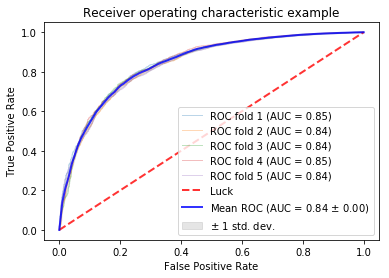

0.9400613

In [38]:
report_classification(df_train,[pipe],cv_strategy)

## GridSearch

In [106]:
from sklearn.model_selection import GridSearchCV

In [246]:
params = {
    'model__min_child_weight': [1, 5, 10],
    'model__gamma': [0.5, 1, 1.5, 2, 5],
    'model__subsample': [0.6, 0.8, 1.0],
    'model__colsample_bytree': [0.6, 0.8, 1.0],
    'model__max_depth': [3, 4, 5]
        }

In [ ]:
%%time
results = cross_val_score(
    GridSearchCV(pipe,
                 cv=StratifiedKFold(n_splits=2),
                 scoring='roc_auc',
                 param_grid=params,
                 verbose=True
                ), 
    X=df_train.copy(),
    y=y,                 
    scoring='roc_auc',
    verbose=True
)

Fitting 2 folds for each of 405 candidates, totalling 810 fits


## Submission

In [245]:
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'feature_eng', 'model', 'feature_eng__default', 'feature_eng__df_out', 'feature_eng__features', 'feature_eng__input_df', 'feature_eng__sparse', 'model__base_score', 'model__booster', 'model__colsample_bylevel', 'model__colsample_bytree', 'model__gamma', 'model__learning_rate', 'model__max_delta_step', 'model__max_depth', 'model__min_child_weight', 'model__missing', 'model__n_estimators', 'model__n_jobs', 'model__nthread', 'model__objective', 'model__random_state', 'model__reg_alpha', 'model__reg_lambda', 'model__scale_pos_weight', 'model__seed', 'model__silent', 'model__subsample', 'model__verbose'])